### Week 2: Pre-processing & feature generation
Useful links:  
[Table of PVCs in patients](https://www.physionet.org/physiobank/database/html/mitdbdir/tables.htm#allbeats)  
[Detailed patient records](https://www.physionet.org/physiobank/database/html/mitdbdir/records.htm)  
[wfdb documentation](https://wfdb.readthedocs.io/en/latest/io.html#module-wfdb.io)  
[MIT-BIH Arrhythmia PhysioNet Database](https://physionet.org/physiobank/database/mitdb/)  

#### 1. Split data into train and test set
a) Rebalance so that data is 50/50 PVC/no PVC  
b) Prevent data leakage between sets by making sure not to have same patient's data in both sets  

In [ ]:
# Notes
# Counter(annotation.symbol).keys()
# annotation.symbol.index('V')
# from biosspy import ecg

In [67]:
# Imports
from IPython.display import display
# from collections import Counter
from os import listdir
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np

import wfdb
# from wfdb import processing

In [66]:
def get_window (signals, annotation, sec):
    """
    this function gives a sec-seconds window (sec seconds before, sec seconds after the annotation mark)
    of the ECG signals and assign value 1 if it's PVC beat and 0 otherwise.
    parameter: signals: numpy array containing heart beat record values
               annotation: wfdb.annotation object containing heart beat annotations
               sec: positive integer number indicating the half-width of the window
    return: two lists
            siglist: a list of lists of length 360*2*sec 
            annlist: a list containing 1 if PVC beat, 0 otherwise
    """
    siglist = []
    
    #loop through the annotation.symbol list
    for i in range(len(annotation.symbol)):
        if annotation.symbol[i].upper() == 'V':
            timestamp = annotation.sample[i] #get the timestamp
        
            #test if that timestamp can have sec seconds before and after window
            windowStart = timestamp - sec*annotation.fs
            windowEnd = timestamp + sec*annotation.fs
            if windowStart >= 0 & windowEnd <= len(signals):
                strip = signals[windowStart:windowEnd].flatten().tolist()   # deleted comma after windowEnd
                siglist.append(strip)
    
    return siglist

In [81]:
# Rebalancing
# 1. Read all wfdb records in MITBIH dataset
# 2. Get 10s window surrounding verified PVCs
# *note: rdrecord and rdsamp functions don't work as well using local directory,
# so will get filenames from local, then pull from remote MIT-BIH physionet database

pvc_dict = {}     # patient: [PVC 1 window, PVC 2 window, ...]
half_window = 1   # must be an int
directory = 'MITBIH'     # get filenames from local
files = [f.split('.')[0] for f in listdir(directory) if f.endswith('.hea')]
print('Searching for all ' + str(2*half_window) + 's windows surrounding verified PVCs ...')
for filename in files:
    signals, fields = wfdb.rdsamp(filename, pb_dir='mitdb')
    annotation = wfdb.rdann(filename, 'atr', pb_dir='mitdb')

    sig_list = get_window(signals, annotation, half_window)
    pvc_dict[filename] = sig_list
    print(str(len(sig_list)) + ' PVCs found in record ' + filename)

Searching for all 2s windows surrounding verified PVCs ...
1 PVCs found in record 100
0 PVCs found in record 101
4 PVCs found in record 102
0 PVCs found in record 103
2 PVCs found in record 104
41 PVCs found in record 105
520 PVCs found in record 106
59 PVCs found in record 107
17 PVCs found in record 108
38 PVCs found in record 109
1 PVCs found in record 111
0 PVCs found in record 112
0 PVCs found in record 113
43 PVCs found in record 114
0 PVCs found in record 115
109 PVCs found in record 116
0 PVCs found in record 117
16 PVCs found in record 118
444 PVCs found in record 119
1 PVCs found in record 121
0 PVCs found in record 122
3 PVCs found in record 123
47 PVCs found in record 124
825 PVCs found in record 200
198 PVCs found in record 201
19 PVCs found in record 202
444 PVCs found in record 203
71 PVCs found in record 205
104 PVCs found in record 207
991 PVCs found in record 208
1 PVCs found in record 209
194 PVCs found in record 210
0 PVCs found in record 212
220 PVCs found in recor

### get_windows output for 10s window (differences bolded, MIT-BIH value in parentheses)
#### the correct values are approached as window size decreases -- this makes sense!

Searching for all 10s windows surrounding verified PVCs ...  
1 PVCs found in record 100  
0 PVCs found in record 101  
4 PVCs found in record 102  
0 PVCs found in record 103  
2 PVCs found in record 104  
41 PVCs found in record 105  
520 PVCs found in record 106  
59 PVCs found in record 107  
17 PVCs found in record 108  
38 PVCs found in record 109  
1 PVCs found in record 111  
0 PVCs found in record 112  
0 PVCs found in record 113  
43 PVCs found in record 114  
0 PVCs found in record 115  
109 PVCs found in record 116  
0 PVCs found in record 117  
16 PVCs found in record 118  
**443 PVCs found in record 119  (444)**  
1 PVCs found in record 121  
0 PVCs found in record 122  
3 PVCs found in record 123  
47 PVCs found in record 124  
**822 PVCs found in record 200 (826)**  
198 PVCs found in record 201  
19 PVCs found in record 202  
444 PVCs found in record 203  
71 PVCs found in record 205  
**103 PVCs found in record 207 (105)**  
**988 PVCs found in record 208 (992)**  
1 PVCs found in record 209  
**193 PVCs found in record 210 (194)**  
0 PVCs found in record 212  
220 PVCs found in record 213  
256 PVCs found in record 214  
164 PVCs found in record 215  
162 PVCs found in record 217  
64 PVCs found in record 219  
0 PVCs found in record 220  
**394 PVCs found in record 221 (396)**  
0 PVCs found in record 222  
473 PVCs found in record 223  
362 PVCs found in record 228  
1 PVCs found in record 230  
2 PVCs found in record 231  
0 PVCs found in record 232  
**827 PVCs found in record 233 (831)**  
3 PVCs found in record 234  

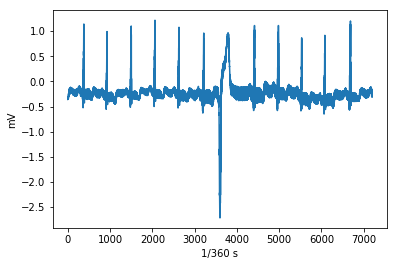

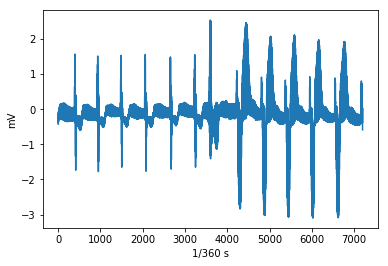

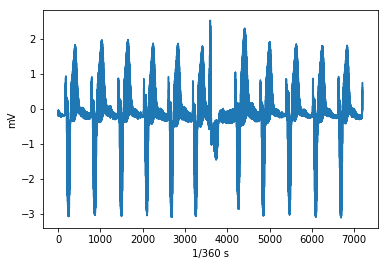

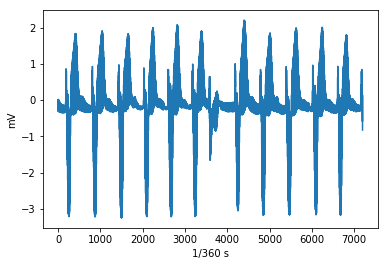

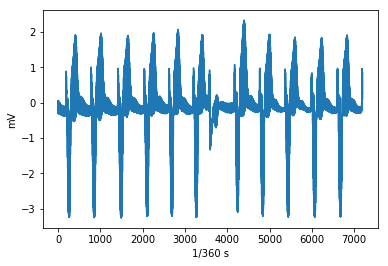

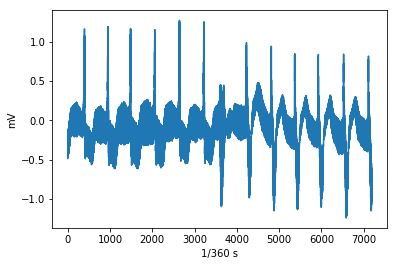

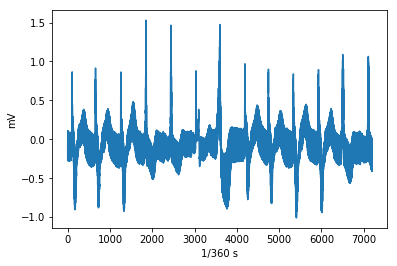

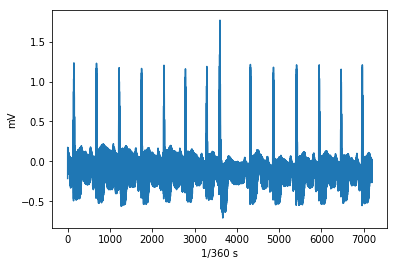

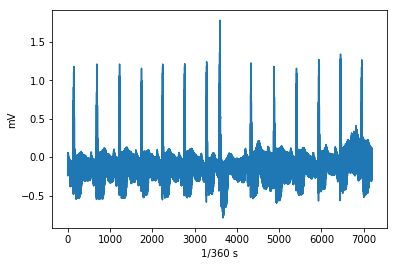

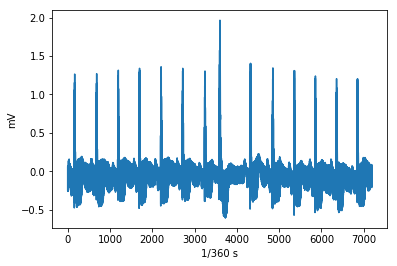

In [78]:
# Visualize a few PVC events
plots_to_show = 10
plotted = 1
for record_num, pvc_list in pvc_dict.items():
    for pvc_event in pvc_list:
        if plotted <= plots_to_show:
            plt.figure()
            plt.plot(pvc_event)
            plt.xlabel('1/360 s')
            plt.ylabel('mV')
            plt.show()
            plotted += 1
        else: break

In [79]:
# Trying to figure out why figures are so fuzzy

records_to_show = 10
shown = 1
for record_num, pvc_list in pvc_dict.items():
    for pvc_event in pvc_list:
        if shown <= records_to_show:
            print(pvc_event)
            print('\n\n\n')
            shown += 1
        else: break

[-0.36, -0.36, -0.36, -0.33, -0.36, -0.315, -0.355, -0.31, -0.335, -0.305, -0.345, -0.3, -0.35, -0.295, -0.335, -0.27, -0.32, -0.245, -0.305, -0.245, -0.305, -0.23, -0.305, -0.215, -0.295, -0.21, -0.28, -0.2, -0.265, -0.175, -0.25, -0.175, -0.24, -0.17, -0.24, -0.185, -0.24, -0.17, -0.245, -0.155, -0.23, -0.145, -0.23, -0.14, -0.225, -0.135, -0.23, -0.155, -0.245, -0.145, -0.24, -0.14, -0.23, -0.125, -0.23, -0.125, -0.23, -0.13, -0.225, -0.13, -0.25, -0.14, -0.23, -0.135, -0.23, -0.115, -0.215, -0.135, -0.22, -0.135, -0.235, -0.14, -0.23, -0.14, -0.235, -0.13, -0.225, -0.13, -0.22, -0.135, -0.21, -0.135, -0.22, -0.15, -0.23, -0.15, -0.225, -0.15, -0.215, -0.145, -0.21, -0.13, -0.215, -0.145, -0.235, -0.15, -0.235, -0.15, -0.23, -0.145, -0.22, -0.135, -0.22, -0.145, -0.215, -0.155, -0.22, -0.175, -0.245, -0.165, -0.245, -0.155, -0.245, -0.145, -0.25, -0.145, -0.255, -0.16, -0.26, -0.17, -0.265, -0.175, -0.26, -0.165, -0.26, -0.16, -0.245, -0.155, -0.255, -0.165, -0.26, -0.18, -0.275, -0

In [82]:
# Get same number of 10s windows NOT containing PVCs so that ratio of PVCs/no PVCs in training set is 50/50
pvc_count = sum(len(pvc_list) for record, pvc_list in pvc_dict.items())


import random
# Randomly sample records to obtain <pvc_count> 10s windows NOT containing PVCs
def get_nonPVC_window(signals, annotation, sec, count)
    siglist = []

    #randomly loop through the annotation.symbol list
    for n in range(count):
        i = random.randint(0, len(annotation.symbol))
        if annotation.symbol[i].upper() == 'N' or annotation.symbol[i] == '.':
            timestamp = annotation.sample[i] #get the timestamp
        
            #test if that timestamp can have sec seconds before and after window
            windowStart = timestamp - sec*annotation.fs
            windowEnd = timestamp + sec*annotation.fs
            if windowStart >= 0 & windowEnd <= len(signals):
                strip = signals[windowStart:windowEnd].flatten().tolist()   # deleted comma after windowEnd
                siglist.append(strip)
    
    return siglist

7126
